In [381]:
from torch import nn
from torch.ao.nn.quantized import Dropout
import torch.nn.functional as F
import wandb
import torch

import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Normalization

In [382]:
#load data

path = '../dataset'
energy_interval = 0.3

augmented = True

if augmented:
	x_train = np.load(f'{path}/x_train_augmented_{energy_interval}.npy')
	y_train = np.load(f'{path}/y_train_augmented_{energy_interval}.npy')
else:
	x_train = np.load(f'{path}/x_train_{energy_interval}.npy')
	y_train = np.load(f'{path}/y_train_{energy_interval}.npy')
x_test = np.load(f'{path}/x_test_{energy_interval}.npy')
y_test = np.load(f'{path}/y_test_{energy_interval}.npy')


In [383]:
mix_x_test = np.load(f'{path}/mix_x_test.npy')
mix_y_test = np.load(f'{path}/mix_y_test.npy')

mix_x_train = np.load(f'{path}/mix_x_train.npy')
mix_y_train = np.load(f'{path}/mix_y_train.npy')

In [384]:
mix_x_train.shape, mix_y_train.shape, mix_x_test.shape, mix_y_test.shape

((31500, 1734), (31500, 8), (3500, 1734), (3500, 8))

In [385]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(37424, 1734) (37424, 8) (1170, 1734) (1170, 8)


In [386]:
x_train = np.concatenate((x_train, mix_x_train))
y_train = np.concatenate((y_train, mix_y_train))

x_test = np.concatenate((x_test, mix_x_test))
y_test = np.concatenate((y_test, mix_y_test))

In [387]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68924, 1734), (68924, 8), (4670, 1734), (4670, 8))

## Hyperparameter Tuning

In [388]:
learning_rate = 0.001
batch_size = 256
num_epochs = 50

## Model Training

### Model Definitions

In [413]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.01):
        super(SimpleNN, self).__init__()

        self.fc1 = nn.Linear(input_size, int(input_size / 2))
        self.bn1 = nn.BatchNorm1d(int(input_size / 2))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(int(input_size / 2), int(input_size / 2))
        self.bn2 = nn.BatchNorm1d(int(input_size / 2))

        self.fc3 = nn.Linear(int(input_size / 2), int(input_size / 4))
        self.bn3 = nn.BatchNorm1d(int(input_size / 4))

        self.fc4 = nn.Linear(int(input_size / 4), 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.fc6 = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc4(out)
        out = self.bn4(out)
        out = self.relu(out)

        out = self.fc5(out)
        out = self.bn5(out)
        out = self.relu(out)

        out = self.fc6(out)

        return out

In [414]:
# Make data loaders

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Training Loop

In [415]:
# model training
def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, architecture):
	total_step = len(train_loader)
	for epoch in range(num_epochs):
		for i, (images, labels) in enumerate(train_loader):
			images = images.to(device)
			labels = labels.to(device)
			if architecture == 'CNN':
				images = images.unsqueeze(1)
			outputs = model(images)
			loss = criterion(outputs, labels)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			if (i+1) % 100 == 0:
				print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
					   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
				# wandb.log({'training_loss': loss.item()})
		val_loss = 0
		with torch.no_grad():
			for i, (images, labels) in enumerate(test_loader):
				images = images.to(device)
				labels = labels.to(device)
				if architecture == 'CNN':
					images = images.unsqueeze(1)
				outputs = model(images)
				# outputs = F.log_softmax(outputs, dim=1)
				# labels = F.softmax(labels, dim=1)
				val_loss += criterion(outputs, labels)
		print('Validation loss: {:.4f}'.format(val_loss/testing_size))
		# wandb.log({'validation_loss': val_loss/testing_size})
	# break
	return model

In [416]:
input_size = x_train.shape[1]
num_classes = y_train.shape[1]
lr = learning_rate
training_size = len(train_loader)
testing_size = len(test_loader)
# model = CNN1D(num_classes).to(device)
model = SimpleNN(input_size, num_classes).to(device)
# model = SimpleRNN(num_classes=num_classes).to(device)
batch_size = batch_size
num_epochs = num_epochs
architecture = 'FNN' if isinstance(model, SimpleNN) else 'CNN'
# architecture = 'FNN' if isinstance(model, SimpleNN) else 'RNN'

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model = train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, architecture)


Epoch [1/50], Step [100/270], Loss: 0.0431
Epoch [1/50], Step [200/270], Loss: 0.0298
Validation loss: 0.0250
Epoch [2/50], Step [100/270], Loss: 0.0287
Epoch [2/50], Step [200/270], Loss: 0.0248
Validation loss: 0.0247
Epoch [3/50], Step [100/270], Loss: 0.0219
Epoch [3/50], Step [200/270], Loss: 0.0213
Validation loss: 0.0215
Epoch [4/50], Step [100/270], Loss: 0.0254
Epoch [4/50], Step [200/270], Loss: 0.0187
Validation loss: 0.0212
Epoch [5/50], Step [100/270], Loss: 0.0174
Epoch [5/50], Step [200/270], Loss: 0.0207
Validation loss: 0.0213
Epoch [6/50], Step [100/270], Loss: 0.0173
Epoch [6/50], Step [200/270], Loss: 0.0223
Validation loss: 0.0207
Epoch [7/50], Step [100/270], Loss: 0.0157
Epoch [7/50], Step [200/270], Loss: 0.0171
Validation loss: 0.0208
Epoch [8/50], Step [100/270], Loss: 0.0172
Epoch [8/50], Step [200/270], Loss: 0.0235
Validation loss: 0.0204
Epoch [9/50], Step [100/270], Loss: 0.0176
Epoch [9/50], Step [200/270], Loss: 0.0201
Validation loss: 0.0207
Epoch [10/

## Performance Analysis

In [417]:
#predict average oxidation state

def predict_avg_oxi_state(model, x):

	x = torch.Tensor(x).to(device)
	output = model(x).detach()
	return output

output = predict_avg_oxi_state(model, x_test)


In [418]:
# print(output.numpy(), y_test)
oxi_states = np.array(list(range(0,8)))
avg_oxi_state = np.dot(y_test, oxi_states)
avg_oxi_state_predicted = np.dot(output.numpy(), oxi_states)

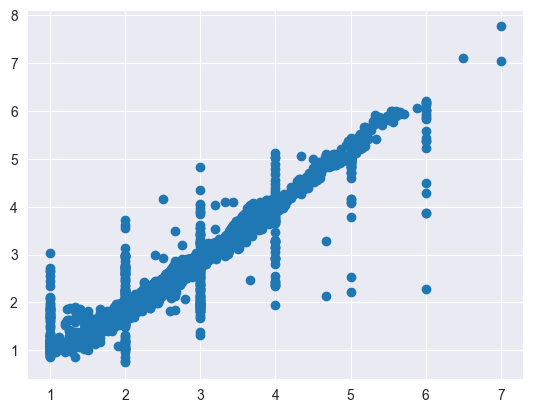

0.9235793298545513


In [419]:
from sklearn.metrics import confusion_matrix, r2_score
import matplotlib.pyplot as plt
# confusion_matrix(avg_oxi_state, avg_oxi_state_predicted)
plt.plot(avg_oxi_state, avg_oxi_state_predicted, 'o')
plt.show()

print(r2_score(avg_oxi_state, avg_oxi_state_predicted))

In [398]:
# np.save(f'y_test_used.npy', y_test)
# np.save(f'output_fnn.npy', output.numpy())